# Teleportation

In [1]:
from qat.lang.AQASM import *

`_a` is for Alice, `_b` is for Bob, `_c` stands for classical

In [2]:
pr = Program()
to_teleport_a = pr.qalloc()
epr_pair_a = pr.qalloc()
epr_pair_b = pr.qalloc()

epr_pair_a_c = pr.calloc()
to_teleport_a_c = pr.calloc()

Prepare the EPR pair

In [3]:
pr.apply(H, epr_pair_a)
pr.apply(CNOT, epr_pair_a, epr_pair_b)

Now Alice has her half of the EPR pair (`epr_pair_a`) and Bob the other one (`epr_pair_b`).
We now prepare a random states on the qubit Alice wants to teleport.

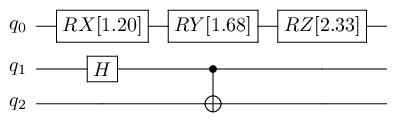

In [4]:
from random import random
from math import pi

pr.apply(RX(random() * pi), to_teleport_a)
pr.apply(RY(random() * pi), to_teleport_a)
pr.apply(RZ(random() * pi), to_teleport_a)

circ = pr.to_circ()
%qatdisplay circ

In order to show the original states contained into the `to_teleport` qubit, we clone the `Program` object. In other words, the idea is to show the state we would have obtained before the teleportation.

In [5]:
import copy
pr2 = copy.deepcopy(pr)

Let's try to simulate the program.

In [6]:
from qat.qpus import PyLinalg

qpu = PyLinalg()

res = qpu.submit(circ.to_job())
for sample in res:
    print(f"State {sample.state} with amplitude {sample.amplitude}")

State |0>|0>|0> with amplitude (0.42691648150023087-0.24000101522439282j)
State |0>|1>|1> with amplitude (0.42691648150023087-0.24000101522439282j)
State |1>|0>|0> with amplitude (0.41606081456810307+0.29501733694081467j)
State |1>|1>|1> with amplitude (0.41606081456810307+0.29501733694081467j)


If we want to measure only the probability of the `to_teleport` register, we do as seen before

In [7]:
res = qpu.submit(circ.to_job(qubits=[to_teleport_a]))
for sample in res:
    print(f"State {sample.state} with probability {sample.probability}")

State |0> with probability 0.47971633897055244
State |1> with probability 0.5202836610294472


Let's proceed to teleport the state. First Alice interacts her `to_teleport` qubit with her half of the EPR pair.

In [8]:
pr2.apply(CNOT, to_teleport_a, epr_pair_a)
pr2.apply(H, to_teleport_a)
pr2.measure(to_teleport_a, to_teleport_a_c)
pr2.measure(epr_pair_a, epr_pair_a_c)

Then she sends her measured qubits to Bob which, depeding on their value being 0 or 1, performes the classically controlled `X` and `Z` operations on his own half of the EPR pair.

In [9]:
pr2.cc_apply(epr_pair_a_c, X, epr_pair_b)
pr2.cc_apply(to_teleport_a_c, Z, epr_pair_b)

circ2 = pr2.to_circ()

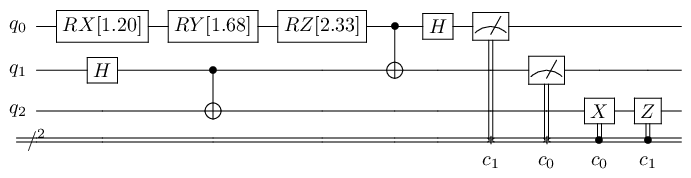

In [10]:
%qatdisplay circ2

Time to simulate

In [11]:
res2 = qpu.submit(circ2.to_job(qubits=[epr_pair_b]))

for sample in res2:
    print(f"State {sample.state} with probability {sample.probability}")

State |0> with probability 0.47971633897055244
State |1> with probability 0.5202836610294475
